In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import chi2_contingency, ttest_ind, ks_2samp

In [15]:
# Load Data
file_path = './Resources/loan_data.csv'
data = pd.read_csv(file_path)

In [16]:
# Preprocessing
# Convert categorical variables to numerical
label_encoders = {}
categorical_columns = ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [17]:
# Ensure target column is binary
assert set(data['loan_status'].unique()) == {0, 1}, "Target variable is not binary."

In [18]:
# Exploratory Data Analysis
print("Data Overview:\n", data.describe())

Data Overview:
          person_age  person_gender  person_education  person_income  \
count  45000.000000   45000.000000      45000.000000   4.500000e+04   
mean      27.764178       0.552022          1.743933   8.031905e+04   
std        6.045108       0.497292          1.479148   8.042250e+04   
min       20.000000       0.000000          0.000000   8.000000e+03   
25%       24.000000       0.000000          0.000000   4.720400e+04   
50%       26.000000       1.000000          1.000000   6.704800e+04   
75%       30.000000       1.000000          3.000000   9.578925e+04   
max      144.000000       1.000000          4.000000   7.200766e+06   

       person_emp_exp  person_home_ownership     loan_amnt   loan_intent  \
count    45000.000000           45000.000000  45000.000000  45000.000000   
mean         5.410333               1.696622   9583.157556      2.525911   
std          6.063532               1.440497   6314.886691      1.728305   
min          0.000000               0.00

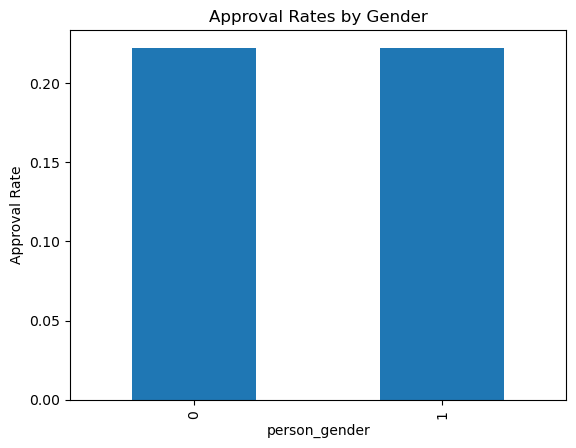

In [19]:
# Gender Bias Analysis
gender_counts = data.groupby('person_gender')['loan_status'].mean()
gender_counts.plot(kind='bar', title='Approval Rates by Gender')
plt.ylabel('Approval Rate')
plt.show()

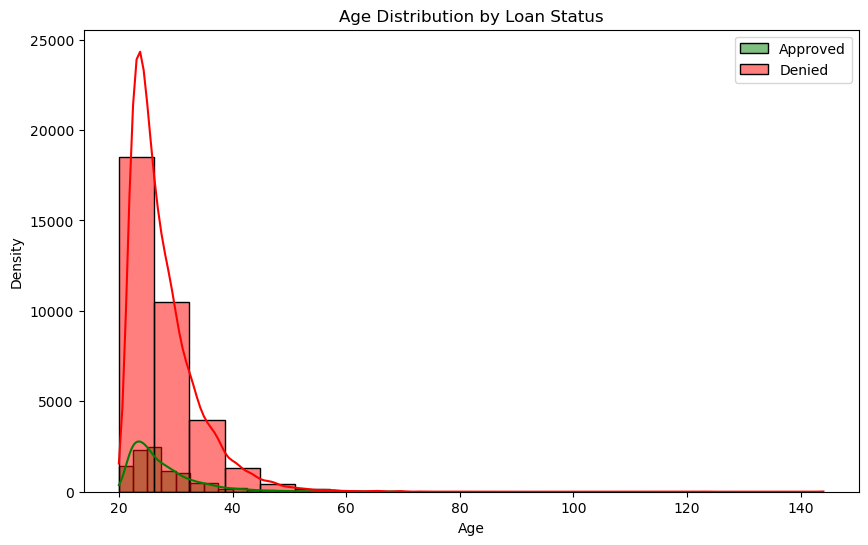

In [20]:
# Age Bias Analysis
plt.figure(figsize=(10, 6))
sns.histplot(data[data['loan_status'] == 1]['person_age'], kde=True, label='Approved', color='green', bins=20)
sns.histplot(data[data['loan_status'] == 0]['person_age'], kde=True, label='Denied', color='red', bins=20)
plt.legend()
plt.title('Age Distribution by Loan Status')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

In [21]:
# Approval rates by age group
data['age_group'] = pd.cut(data['person_age'], bins=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65], right=False)
approval_rates_by_age_group = data.groupby('age_group')['loan_status'].mean()
print("Approval Rates by Age Group:\n", approval_rates_by_age_group)

Approval Rates by Age Group:
 age_group
[20, 25)    0.235597
[25, 30)    0.218986
[30, 35)    0.207436
[35, 40)    0.211765
[40, 45)    0.202169
[45, 50)    0.216374
[50, 55)    0.246305
[55, 60)    0.218391
[60, 65)    0.400000
Name: loan_status, dtype: float64


C:\Users\adminpl\AppData\Local\Temp\ipykernel_29876\4072970061.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  approval_rates_by_age_group = data.groupby('age_group')['loan_status'].mean()


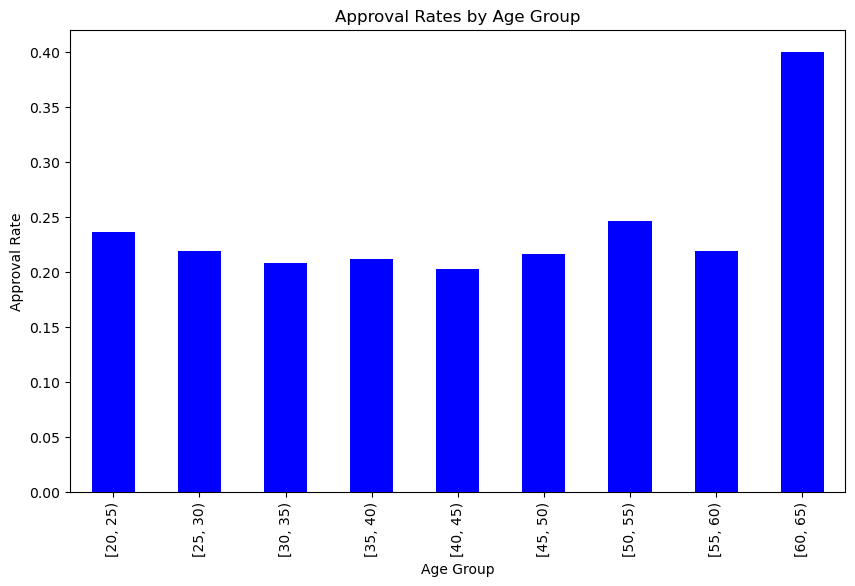

In [22]:
# Plotting approval rates by age group
approval_rates_by_age_group.plot(kind='bar', title='Approval Rates by Age Group', color='blue', figsize=(10, 6))
plt.ylabel('Approval Rate')
plt.xlabel('Age Group')
plt.show()

In [23]:
# Identify age groups with disproportionately low approval rates
low_approval_groups = approval_rates_by_age_group[approval_rates_by_age_group < approval_rates_by_age_group.mean()]
print("Age Groups with Disproportionately Low Approval Rates:\n", low_approval_groups)


Age Groups with Disproportionately Low Approval Rates:
 age_group
[20, 25)    0.235597
[25, 30)    0.218986
[30, 35)    0.207436
[35, 40)    0.211765
[40, 45)    0.202169
[45, 50)    0.216374
[55, 60)    0.218391
Name: loan_status, dtype: float64


In [24]:
# Statistical Tests for Bias
# Gender Bias (Chi-Square Test)
gender_contingency = pd.crosstab(data['person_gender'], data['loan_status'])
chi2, p, _, _ = chi2_contingency(gender_contingency)
print(f"Gender Bias Chi-Square Test: chi2 = {chi2:.3f}, p-value = {p:.3f}")
if p < 0.05:
    print("Conclusion: The data shows evidence of gender-based discrimination.")
else:
    print("Conclusion: No significant gender-based discrimination detected.")


Gender Bias Chi-Square Test: chi2 = 0.012, p-value = 0.914
Conclusion: No significant gender-based discrimination detected.


In [25]:
# Age Bias (T-Test)
approved_age = data[data['loan_status'] == 1]['person_age']
denied_age = data[data['loan_status'] == 0]['person_age']
t_stat, p_value = ttest_ind(approved_age, denied_age)
print(f"Age Bias T-Test: t-statistic = {t_stat:.3f}, p-value = {p_value:.3f}")
if p_value < 0.05:
    print("Conclusion: The data shows evidence of age-based discrimination.")
else:
    print("Conclusion: No significant age-based discrimination detected.")

Age Bias T-Test: t-statistic = -4.557, p-value = 0.000
Conclusion: The data shows evidence of age-based discrimination.


In [26]:
# Kolmogorov-Smirnov Test for age distributions
ks_stat, ks_p = ks_2samp(approved_age, denied_age)
print(f"Kolmogorov-Smirnov Test: KS Statistic = {ks_stat:.3f}, p-value = {ks_p:.3f}")
if ks_p < 0.05:
    print("Conclusion: The age distributions between approved and denied applicants differ significantly.")
else:
    print("Conclusion: No significant difference in age distributions between approved and denied applicants.")


Kolmogorov-Smirnov Test: KS Statistic = 0.031, p-value = 0.000
Conclusion: The age distributions between approved and denied applicants differ significantly.
